Script 5:
- Clean and preprocess bureau and bureau_balance datasets
- Combines it with the main datasets
- Create bureau_new: each id has only one data points with created features.

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

we cleaned the original 'bureau' datasets and saved it as 'bureau_clean'

In [3]:
#load data
path='./home-credit-default-risk/'
df = pd.read_csv(path + 'application_train.csv')
bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
bureau = pd.read_csv(path + 'bureau_clean.xlsx')

In [4]:
#drop the unnamed column
bureau.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
# mearge the bureau dataset with main dataset's id and target feature
df_bureau = pd.merge(df[['SK_ID_CURR','TARGET']],bureau,left_on='SK_ID_CURR',right_on='SK_ID_CURR')

briefly look at the correlation between target and other features

In [5]:
df_bureau_corr = df_bureau.corr()

In [6]:
df_bureau_corr['TARGET'].sort_values(ascending = False)[1:11]

DAYS_CREDIT_UPDATE        0.041076
DAYS_ENDDATE_FACT         0.033690
DAYS_CREDIT_ENDDATE       0.024588
AMT_CREDIT_SUM_OVERDUE    0.006253
AMT_CREDIT_SUM_DEBT       0.003128
CREDIT_DAY_OVERDUE        0.002652
CNT_CREDIT_PROLONG        0.001523
SK_ID_CURR               -0.003024
AMT_CREDIT_SUM_LIMIT     -0.004898
SK_ID_BUREAU             -0.009018
Name: TARGET, dtype: float64

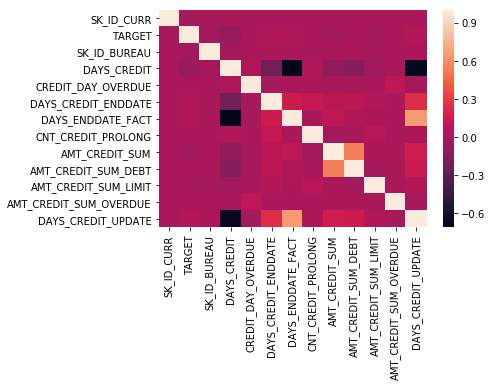

In [7]:
sns.heatmap(df_bureau_corr)

## Categorical feature

In [9]:
#count the number of each credit status
df_credit = pd.get_dummies(df_bureau[['SK_ID_CURR','CREDIT_ACTIVE']])

bureau_new = pd.DataFrame(df_credit.groupby(['SK_ID_CURR']).sum())

bureau_credit_perc = bureau_new.apply(lambda x: x/x.sum(),axis=1)

In [10]:
bureau_new.rename(columns = {'CREDIT_ACTIVE_Bad debt' :'CREDIT_ACTIVE_Bad_Debt'},inplace = True)
#calculate percentage of each credit status
bureau_credit_perc.columns = ['ACTIVE_PERC','BAD_DEBT_PERC','CLOSED_PERC','SOLD_PERC']
bureau_new = pd.merge(bureau_new,bureau_credit_perc,left_on='SK_ID_CURR',right_on='SK_ID_CURR')

In [11]:
#merge with target
bureau_new = pd.merge(df[['SK_ID_CURR','TARGET']],bureau_new,left_on='SK_ID_CURR',right_on='SK_ID_CURR')

In [12]:
#check the distribution for target in 0 and 1
bureau_new[bureau_new['CREDIT_ACTIVE_Closed'] != 0]['TARGET'].value_counts()/bureau_new[bureau_new['CREDIT_ACTIVE_Closed'] != 0]['TARGET'].count()


0    0.927556
1    0.072444
Name: TARGET, dtype: float64

In [13]:
#check the percentage of each category for target 1
bureau_new[bureau_new['TARGET']==1].iloc[:,2:].sum()/bureau_new[bureau_new['TARGET']==1].iloc[:,2:].sum().sum()

CREDIT_ACTIVE_Active      0.373169
CREDIT_ACTIVE_Bad_Debt    0.000030
CREDIT_ACTIVE_Closed      0.471569
CREDIT_ACTIVE_Sold        0.004233
ACTIVE_PERC               0.074804
BAD_DEBT_PERC             0.000006
CLOSED_PERC               0.075268
SOLD_PERC                 0.000921
dtype: float64

In [14]:
#check the percentage of each category for target 0
bureau_new[bureau_new['TARGET']==0].iloc[:,2:].sum()/bureau_new[bureau_new['TARGET']==0].iloc[:,2:].sum().sum()

CREDIT_ACTIVE_Active      0.308410
CREDIT_ACTIVE_Bad_Debt    0.000010
CREDIT_ACTIVE_Closed      0.535861
CREDIT_ACTIVE_Sold        0.003188
ACTIVE_PERC               0.061938
BAD_DEBT_PERC             0.000001
CLOSED_PERC               0.090024
SOLD_PERC                 0.000567
dtype: float64

In [15]:
# total number of loan 
df_loan = pd.DataFrame(df_bureau.groupby(['SK_ID_CURR'])['SK_ID_CURR'].count().rename(columns = {'SK_ID_CURR': 'PAST_LOAN'}).reset_index())
df_loan.rename(columns = {0: 'PAST_LOAN'},inplace=True)
bureau_new = pd.merge(bureau_new,df_loan,left_on='SK_ID_CURR',right_on='SK_ID_CURR')

In [16]:
#distributions for target 1,0 are almost the same
#number of type
number_type = pd.DataFrame(df_bureau.groupby(['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(columns = {'CREDIT_TYPE': 'TYPE_COUNT'}))
bureau_new = pd.merge(bureau_new,number_type,left_on='SK_ID_CURR',right_on='SK_ID_CURR')
#number of currency
number_currency = pd.DataFrame(df_bureau.groupby(['SK_ID_CURR'])['CREDIT_CURRENCY'].nunique().reset_index().rename(columns = {'CREDIT_CURRENCY': 'CURRENCY_COUNT'}))
bureau_new = pd.merge(bureau_new,number_currency,left_on='SK_ID_CURR',right_on='SK_ID_CURR')


In [17]:
#average times of PROLONG
#most are zero
ave_prolong = pd.DataFrame(df_bureau.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index().rename(columns = {'CNT_CREDIT_PROLONG': 'PROLONG_MEAN'}))
bureau_new = pd.merge(bureau_new,ave_prolong,left_on='SK_ID_CURR',right_on='SK_ID_CURR')


## Numeric feature

In [18]:
#average number of credit day overdue
ave_day_overdue = pd.DataFrame(df_bureau.groupby(['SK_ID_CURR'])['CREDIT_DAY_OVERDUE'].mean().reset_index().rename(columns = {'CREDIT_DAY_OVERDUE': 'DAY_OVERDUE_MEAN'}))
bureau_new = pd.merge(bureau_new,ave_day_overdue,left_on='SK_ID_CURR',right_on='SK_ID_CURR')


In [19]:
#average pass the enddate in active status
def pass_end(x1,x2):
    if x1 <0 and x2 == 'Active':
        y = 1
    else:
        y = 0
    return y
#df_bureau['PASS_ENDDATE'] = df_bureau['DAYS_CREDIT_ENDDATE'].apply(lambda x: 1 if x < 0 else 0 )
df_bureau['PASS_ENDDATE'] =df_bureau.apply(lambda x: pass_end(x.DAYS_CREDIT_ENDDATE,x.CREDIT_ACTIVE),axis=1)
ave_pass_endday = pd.DataFrame(df_bureau.groupby(['SK_ID_CURR'])['PASS_ENDDATE'].mean().reset_index().rename(columns = {'PASS_ENDDATE': 'PASS_ENDDATE_MEAN'}))
bureau_new = pd.merge(bureau_new,ave_pass_endday,left_on='SK_ID_CURR',right_on='SK_ID_CURR')


In [20]:
#sum of all credit debt / sum of all amt credit
sum_amt_credit_debt = pd.DataFrame(df_bureau.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index())
sum_amt_credit = pd.DataFrame(df_bureau.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index())
df_sum_amt_credit = pd.merge(sum_amt_credit,sum_amt_credit_debt,left_on='SK_ID_CURR',right_on='SK_ID_CURR')
df_sum_amt_credit['AMT_CREDIT_SUM_RATIO'] = df_sum_amt_credit.AMT_CREDIT_SUM_DEBT/df_sum_amt_credit.AMT_CREDIT_SUM
df_sum_amt_credit['AMT_CREDIT_SUM_RATIO'].fillna(0,inplace = True)
bureau_new = pd.merge(bureau_new,df_sum_amt_credit[['SK_ID_CURR','AMT_CREDIT_SUM_RATIO']],left_on='SK_ID_CURR',right_on='SK_ID_CURR')


In [21]:
# mean of days credit
mean_days_credit = pd.DataFrame(df_bureau.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index().rename(columns = {'DAYS_CREDIT': 'DAYS_CREDIT_MEAN'}))
bureau_new = pd.merge(bureau_new,mean_days_credit,left_on='SK_ID_CURR',right_on='SK_ID_CURR')


In [22]:
#most recent days credit

recent_days_credit = pd.DataFrame(df_bureau[df_bureau['CREDIT_ACTIVE'] == 'Active'].groupby(['SK_ID_CURR'])['DAYS_CREDIT'].\
                                  max().reset_index().\
                                  rename(columns = {'DAYS_CREDIT': 'DAYS_CREDIT_RECENT'}))
bureau_new = pd.merge(bureau_new,recent_days_credit,on='SK_ID_CURR',how='left')

bureau_new.fillna(0,inplace=True)

In [23]:
bureau_new

,SK_ID_CURR,TARGET,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad_Debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,ACTIVE_PERC,BAD_DEBT_PERC,CLOSED_PERC,SOLD_PERC,PAST_LOAN,TYPE_COUNT,CURRENCY_COUNT,PROLONG_MEAN,DAY_OVERDUE_MEAN,PASS_ENDDATE_MEAN,AMT_CREDIT_SUM_RATIO,DAYS_CREDIT_MEAN,DAYS_CREDIT_RECENT
0,100002,1,2,0,6,0,0.250000,0.0,0.750000,0.000000,8,2,1,0.000000,0.0,0.125000,0.284122,874.000000,1042.0
1,100003,0,1,0,3,0,0.250000,0.0,0.750000,0.000000,4,2,1,0.000000,0.0,0.000000,0.000000,1400.750000,606.0
2,100004,0,0,0,2,0,0.000000,0.0,1.000000,0.000000,2,1,1,0.000000,0.0,0.000000,0.000000,867.000000,0.0
3,100007,0,0,0,1,0,0.000000,0.0,1.000000,0.000000,1,1,1,0.000000,0.0,0.000000,0.000000,1149.000000,0.0
4,100008,0,1,0,2,0,0.333333,0.0,0.666667,0.000000,3,1,1,0.000000,0.0,0.000000,0.512454,757.333333,78.0
5,100009,0,4,0,14,0,0.222222,0.0,0.777778,0.000000,18,2,1,0.000000,0.0,0.166667,0.224410,1271.500000,1293.0
6,100010,0,1,0,1,0,0.500000,0.0,0.500000,0.000000,2,2,1,0.000000,0.0,0.000000,0.351523,1939.500000,1138.0
7,100011,0,0,0,4,0,0.000000,0.0,1.000000,0.000000,4,2,1,0.000000,0.0,0.000000,0.000000,1773.000000,0.0
8,100014,0,2,0,6,0,0.250000,0.0,0.750000,0.000000,8,1,1,0.000000,0.0,0.000000,0.277741,1095.375000,423.0
9,100015,0,0,0,4,0,0.000000,0.0,1.000000,0.000000,4,1,1,0.000000,0.0,0.000000,0.000000,947.750000,0.0


In [24]:
bureau_new['TARGET'] = bureau_new['TARGET'].map({1:'Target 1' , 0: 'Target0'})
bureau_new.head()

,SK_ID_CURR,TARGET,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad_Debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,ACTIVE_PERC,BAD_DEBT_PERC,CLOSED_PERC,SOLD_PERC,PAST_LOAN,TYPE_COUNT,CURRENCY_COUNT,PROLONG_MEAN,DAY_OVERDUE_MEAN,PASS_ENDDATE_MEAN,AMT_CREDIT_SUM_RATIO,DAYS_CREDIT_MEAN,DAYS_CREDIT_RECENT
0,100002,Target 1,2,0,6,0,0.250000,0.0,0.750000,0.0,8,2,1,0.0,0.0,0.125,0.284122,874.000000,1042.0
1,100003,Target0,1,0,3,0,0.250000,0.0,0.750000,0.0,4,2,1,0.0,0.0,0.000,0.000000,1400.750000,606.0
2,100004,Target0,0,0,2,0,0.000000,0.0,1.000000,0.0,2,1,1,0.0,0.0,0.000,0.000000,867.000000,0.0
3,100007,Target0,0,0,1,0,0.000000,0.0,1.000000,0.0,1,1,1,0.0,0.0,0.000,0.000000,1149.000000,0.0
4,100008,Target0,1,0,2,0,0.333333,0.0,0.666667,0.0,3,1,1,0.0,0.0,0.000,0.512454,757.333333,78.0


In [26]:
#get all max number for each id
max_info = pd.DataFrame(df_bureau.groupby(['SK_ID_CURR']).max())
max_info.drop(columns = ['SK_ID_BUREAU','CREDIT_CURRENCY','DAYS_CREDIT_ENDDATE'],inplace = True)
max_info = max_info.add_suffix('_MAX')


KeyboardInterrupt



In [ ]:
bureau_new = pd.merge(bureau_new,aa,left_on='SK_ID_CURR',right_on='SK_ID_CURR')

## bureau_balance

In [ ]:
#merge bureau_balance with bureau
bureau_balance_new = pd.merge(df_bureau[['SK_ID_CURR','TARGET','SK_ID_BUREAU']],bureau_balance,left_on='SK_ID_BUREAU',right_on='SK_ID_BUREAU')


In [ ]:
#count the number of each status for each ID
status_dummies = pd.get_dummies(bureau_balance_new[['SK_ID_CURR','STATUS']])
bureau_balance_status = pd.DataFrame(status_dummies.groupby(['SK_ID_CURR']).sum())

In [ ]:
#combine features 
bureau_balance_status['STATUS_2_TO_4'] = bureau_balance_status.STATUS_2+bureau_balance_status.STATUS_3+bureau_balance_status.STATUS_4
bureau_balance_status.drop(columns = ['STATUS_2','STATUS_3','STATUS_4'],inplace = True)

In [ ]:
#calculate percentage of each status
balance_status_perc = bureau_balance_status.apply(lambda x: x/x.sum(),axis=1)

In [ ]:
#merge them together
balance_status_perc.columns = ['STATUS_0_PERC','STATUS_1_PERC','STATUS_5_PERC','STATUS_C_PERC','STATUS_X_PERC','STATUS_2_TO_4_PERC']
bureau_balance_status = pd.merge(bureau_balance_status,balance_status_perc,left_on='SK_ID_CURR',right_on='SK_ID_CURR')

In [ ]:
bureau_new1 = pd.merge(bureau_new,bureau_balance_status,how = 'left',on = 'SK_ID_CURR')

In [ ]:
bureau_new1.isnull().sum()/len(bureau_new1)

In [ ]:
bureau_new1

In [ ]:
#save final datasets with created features
bureau_new1.to_csv('bureau_new.csv',index = False)